In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.append('../../../src/benchmark/')
sys.path.append('../../../src/utils/')
from build_model import resnet50_, densenet161_, fpn_resnet50_classification, xcit_small
from utils import hdf5_dataset, list_to_dict, viz_dataloader
from prediction_analysis import confusion_matrix, plot_cm, prediction_vs_actual, most_confused, show_cm
from style import style


c:\Users\yig319\Anaconda3\envs\symmetry\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(train_dl, label_converter=label_converter)

valid_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(valid_dl, label_converter=label_converter)

cv_atom_ds = hdf5_dataset('../../../datasets/atom_v4_rot_2m_unchunked.h5', folder='test', transform=transforms.ToTensor())
cv_atom_dl = DataLoader(cv_atom_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_atom_dl, label_converter=label_converter)

cv_noise_ds = hdf5_dataset('../../../datasets/noise_v4_rot_2m-test.h5', folder='test', transform=transforms.ToTensor())
cv_noise_dl = DataLoader(cv_noise_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_noise_dl, label_converter=label_converter)

In [6]:
NAME = '01122024-benchmark-DenseNet161-v4_10m'

model = fpn_resnet50_classification(in_channels=3, n_classes=17)
model = torch.load('../../../saved_models/01122024-benchmark-DenseNet161-v4_10m/01122024-benchmark-DenseNet161-v4_10m-epoch-20.pt')
device = torch.device('cuda:3')

### generate confusion matrix

In [4]:
cm = confusion_matrix(model, train_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/DenseNet161/{NAME}-train_imagenet_cm.npy', cm)

cm = confusion_matrix(model, valid_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/DenseNet161/{NAME}-valid_imagenet_cm.npy', cm)

cm = confusion_matrix(model, cv_atom_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/DenseNet161/{NAME}-cv_atom_cm.npy', cm)

cm = confusion_matrix(model, cv_noise_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/DenseNet161/{NAME}-cv_noise_cm.npy', cm)

100%|██████████| 9728/9728 [5:43:10<00:00,  2.12s/it]  


Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,588308.0,588239.0,588239.0,588233.0,588232.0,588231.0,588236.0,588232.0,588239.0,588237.0,588238.0,588239.0,588239.0,588224.0,588239.0,588238.0,588237.0


Accuracy for these batches: 99.96182030543756%


100%|██████████| 1946/1946 [1:08:13<00:00,  2.10s/it]


Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,117670.0,117647.0,117647.0,117647.0,117646.0,117646.0,117648.0,117647.0,117647.0,117646.0,117647.0,117648.0,117647.0,117645.0,117645.0,117646.0,117647.0


Accuracy for these batches: 99.93400052799578%


100%|██████████| 1978/1978 [1:08:35<00:00,  2.08s/it]

Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,270351.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0


Accuracy for these batches: 55.81861806252857%


100%|██████████| 1946/1946 [1:07:28<00:00,  2.08s/it]

Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,117667.0,117588.0,117648.0,117660.0,117656.0,117655.0,117648.0,117631.0,117695.0,117677.0,117621.0,117669.0,117628.0,117634.0,117630.0,117673.0,117620.0


Accuracy for these batches: 96.37915%


### visualize confusions 

printing set for seaborn


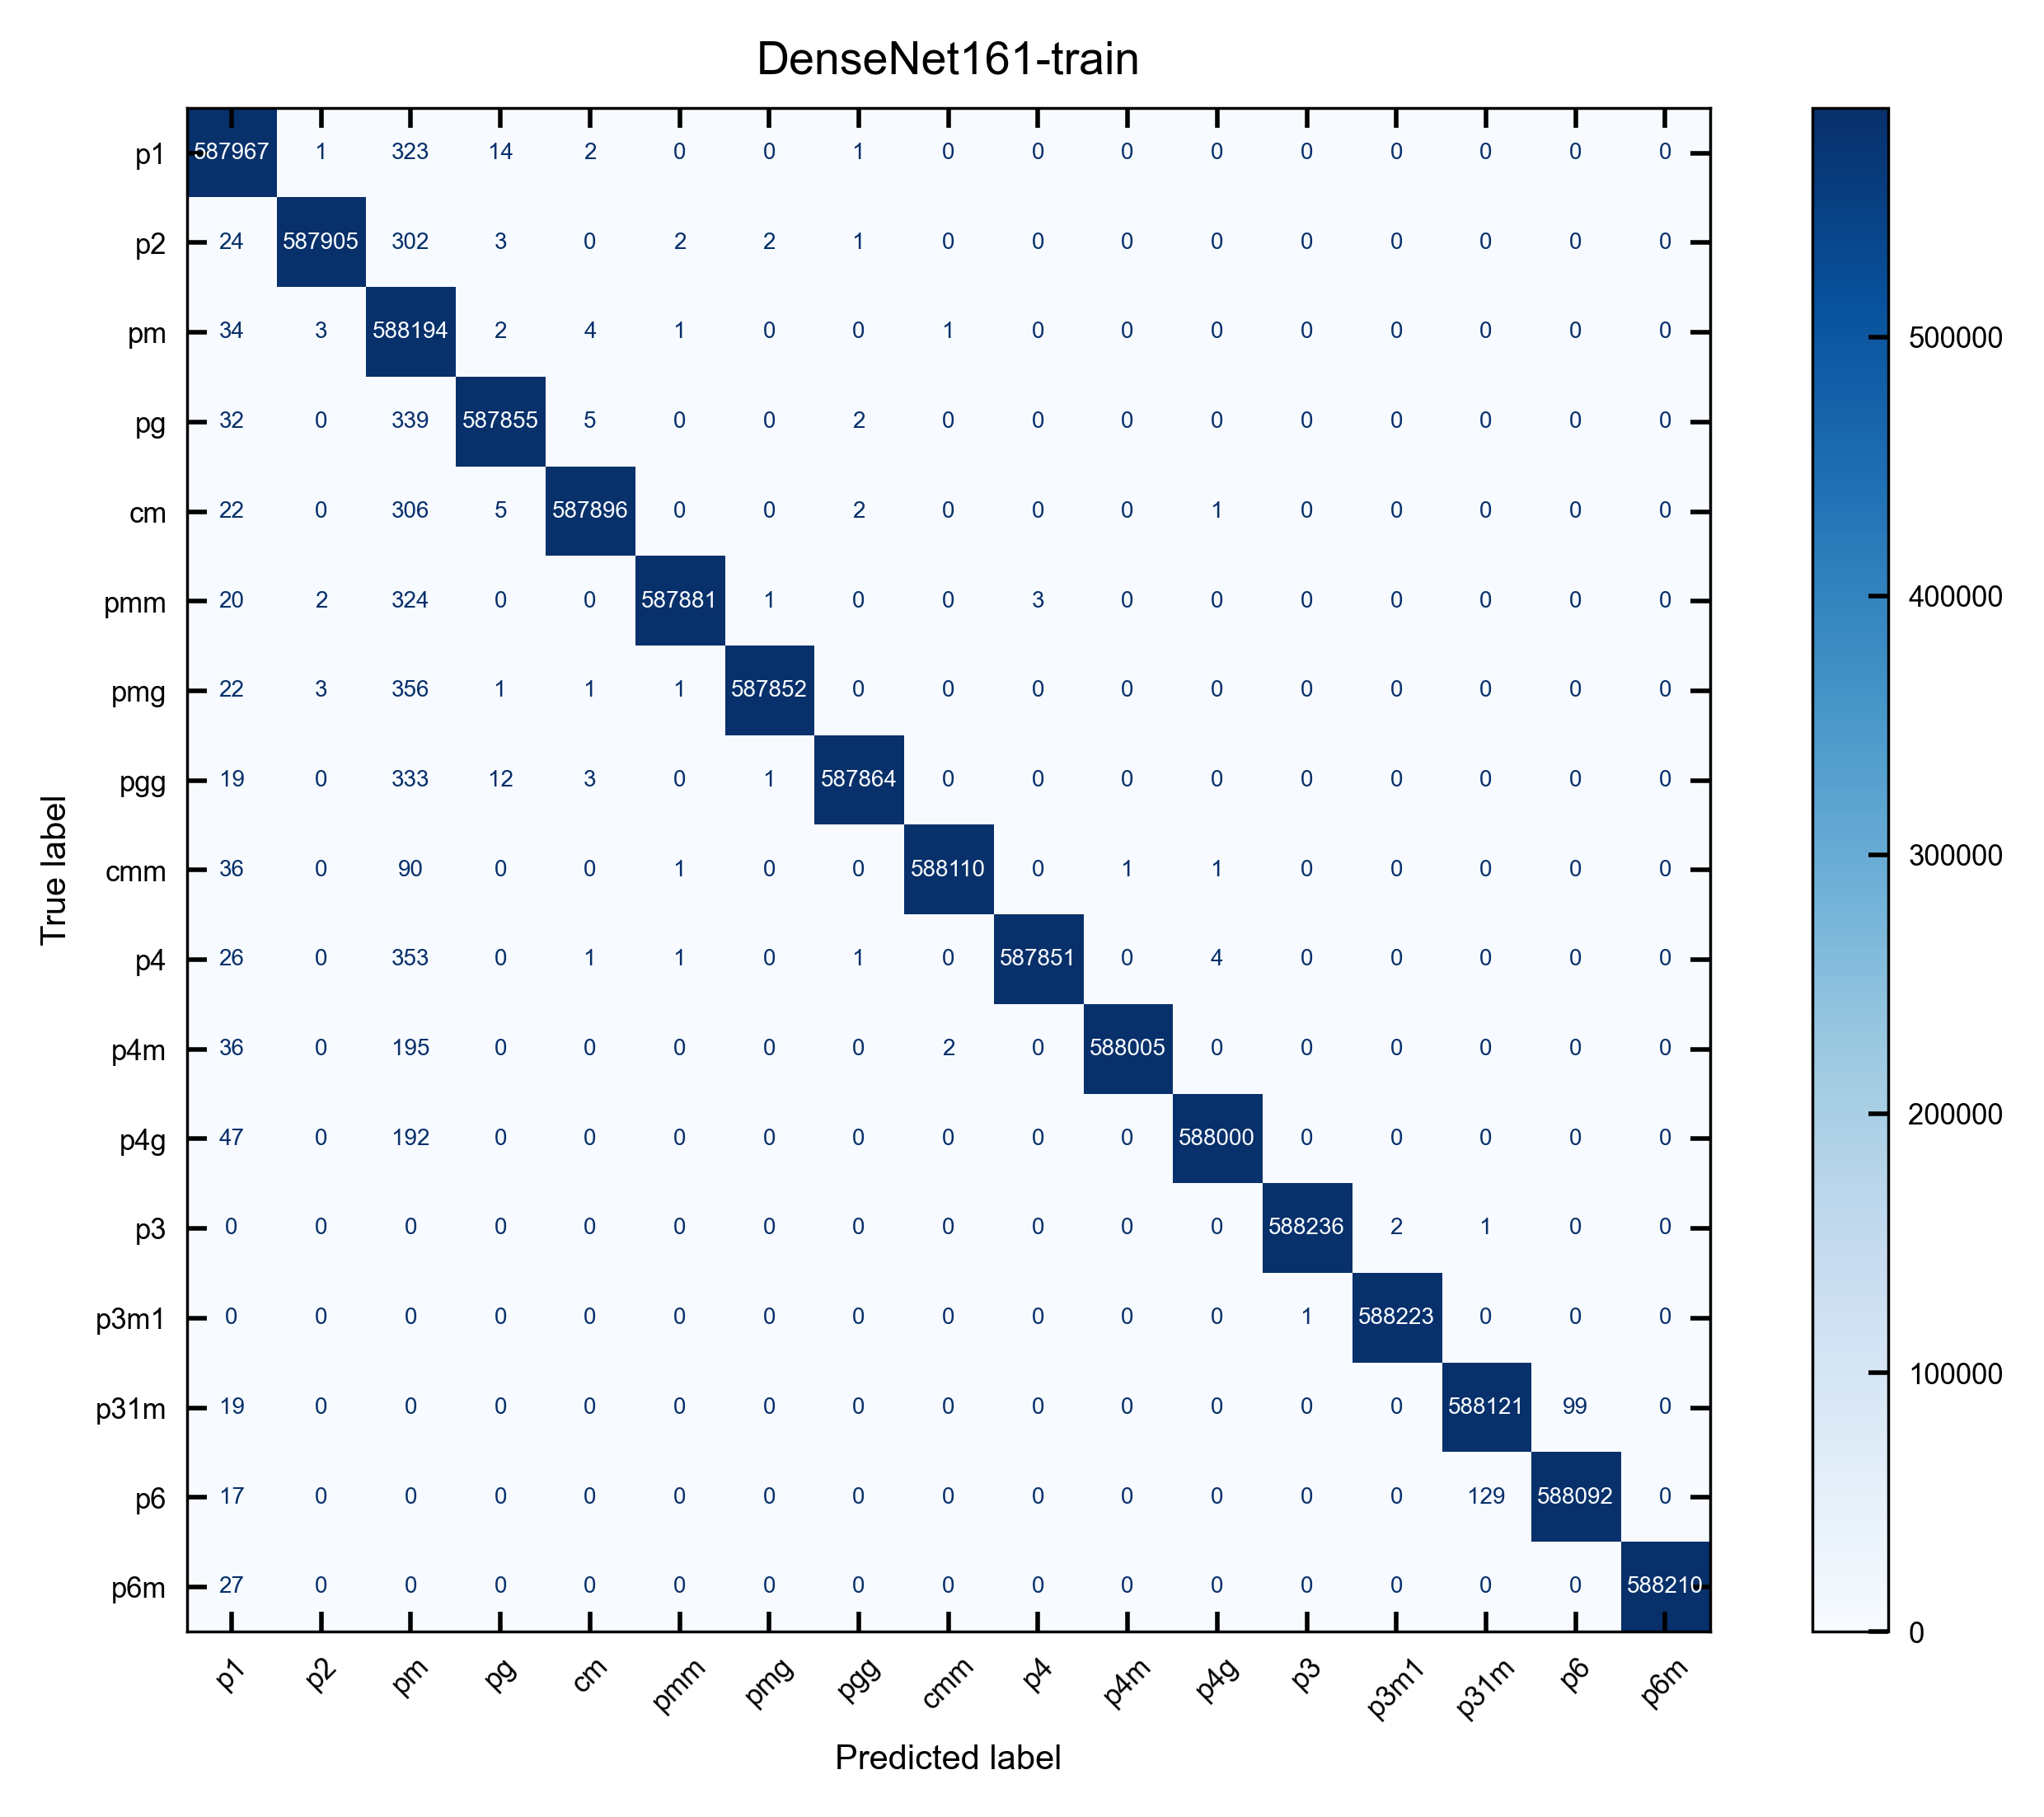

printing set for seaborn


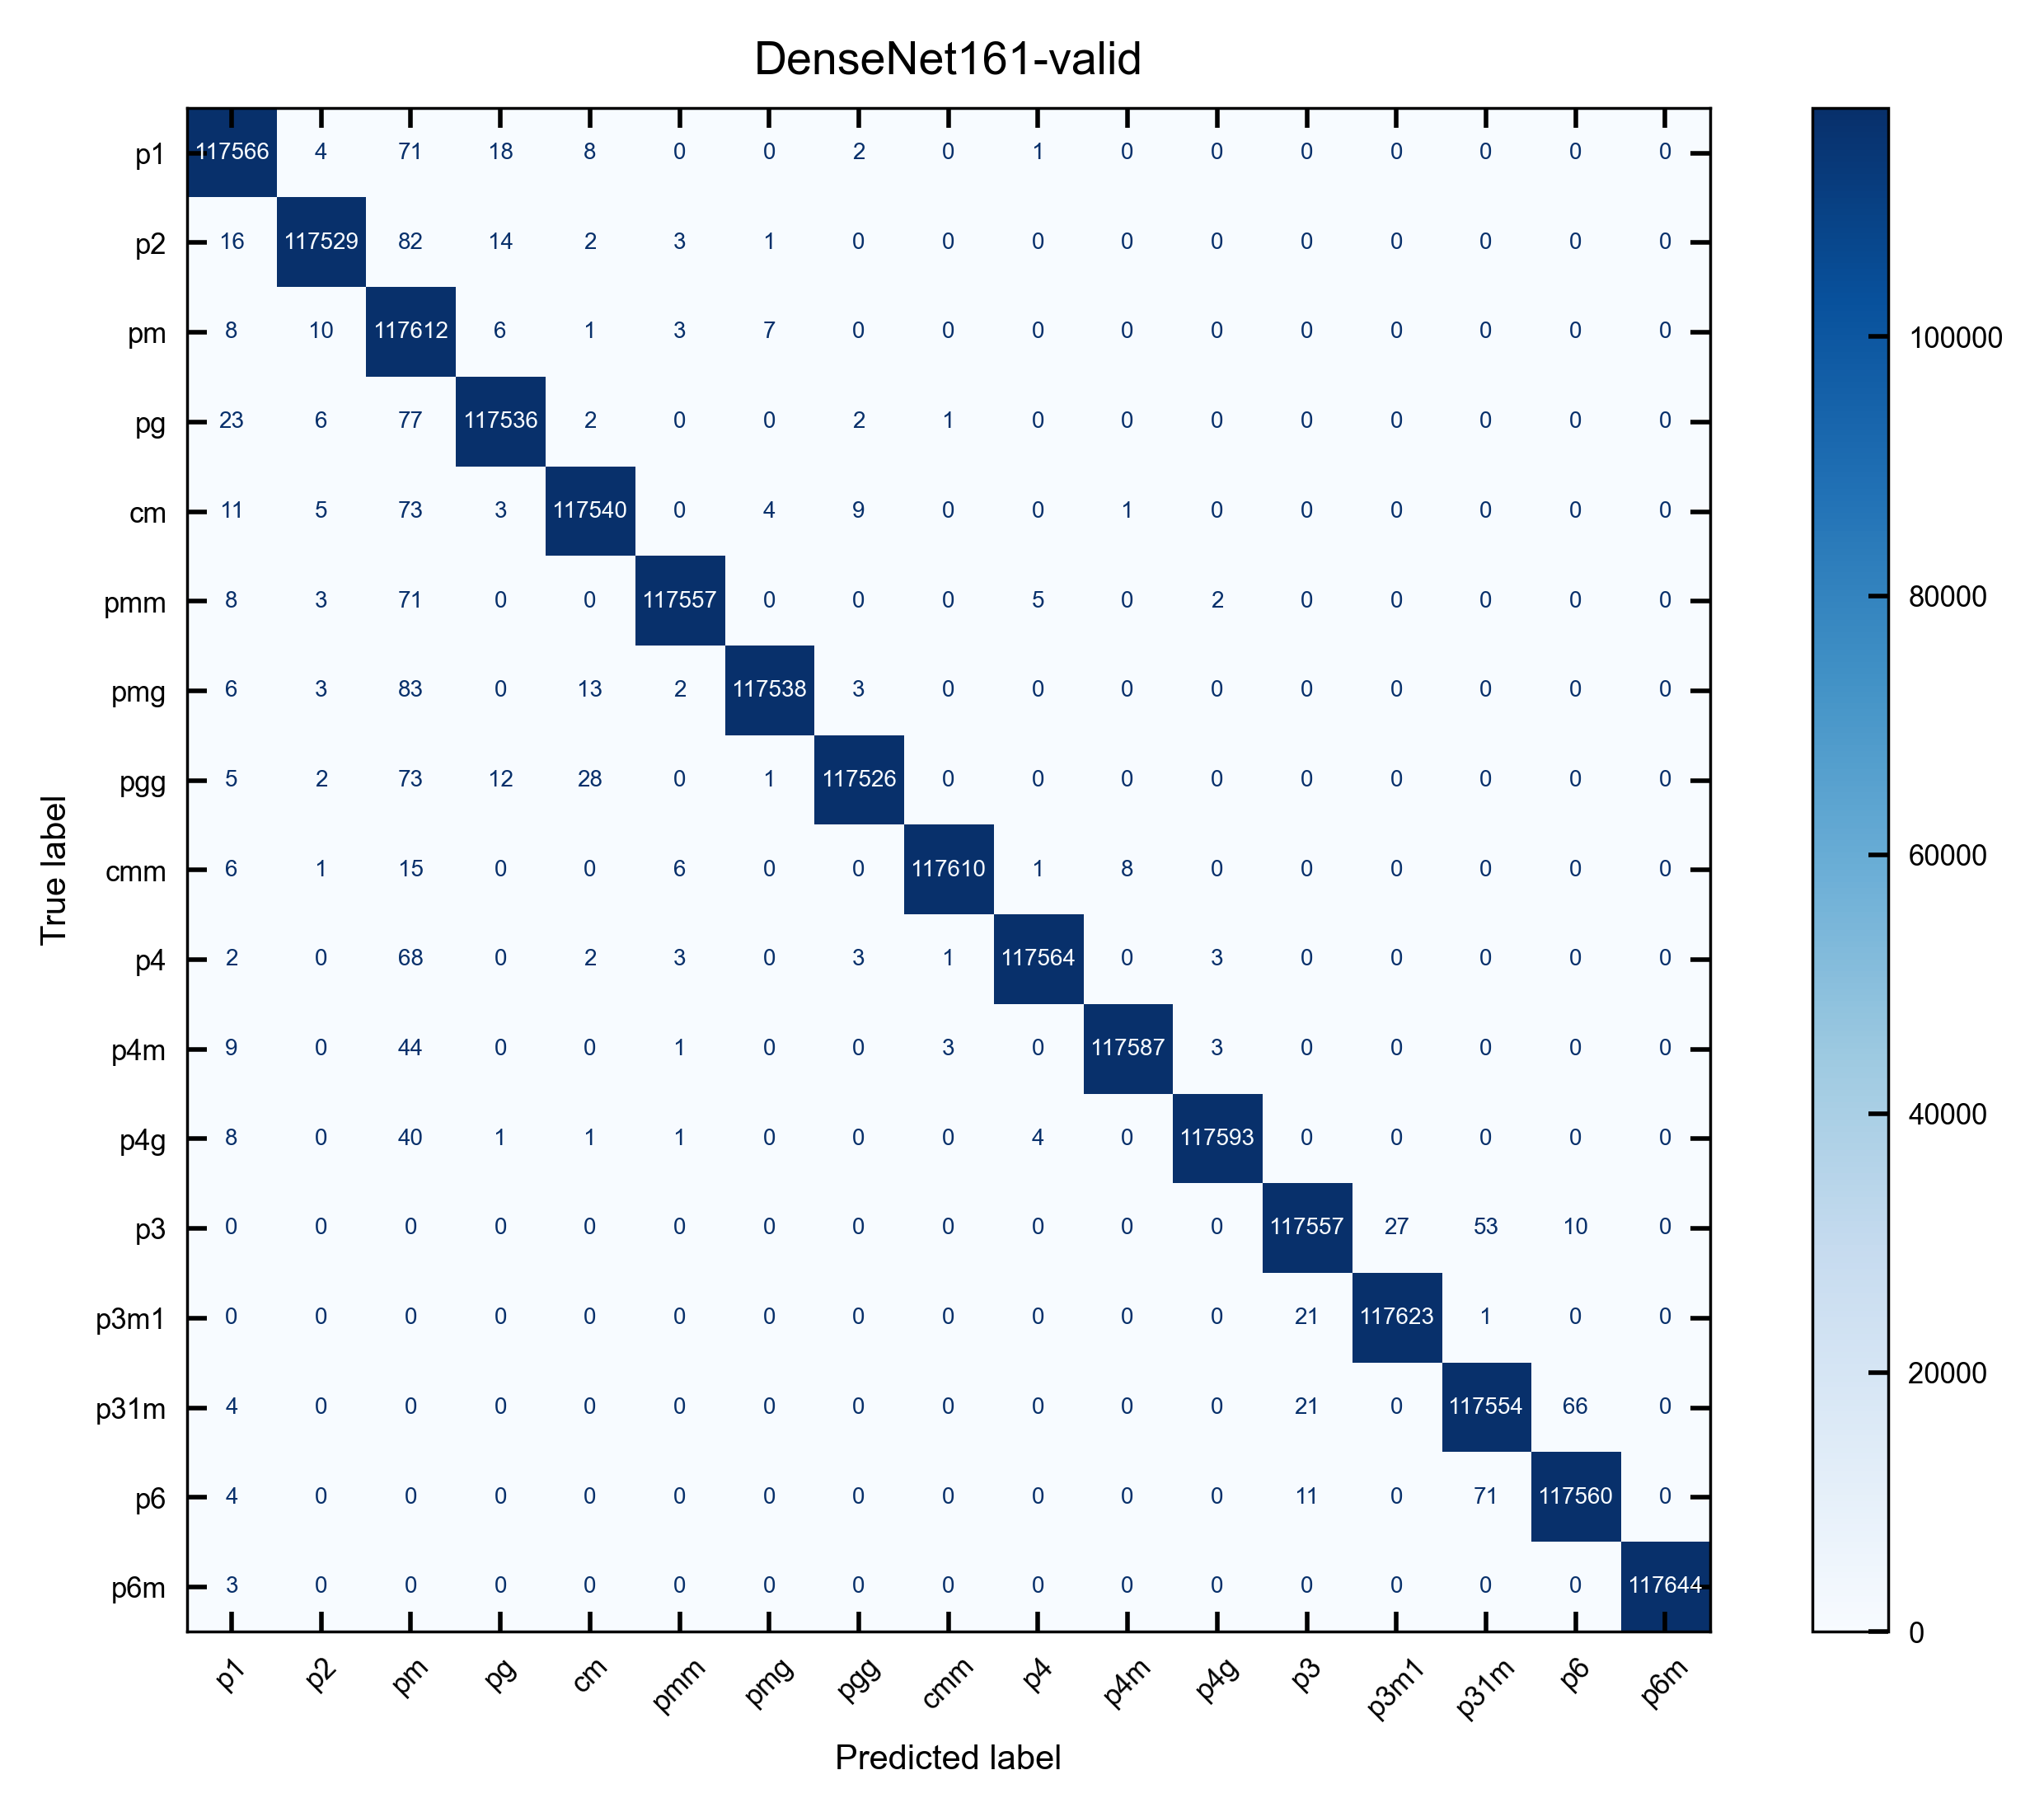

printing set for seaborn


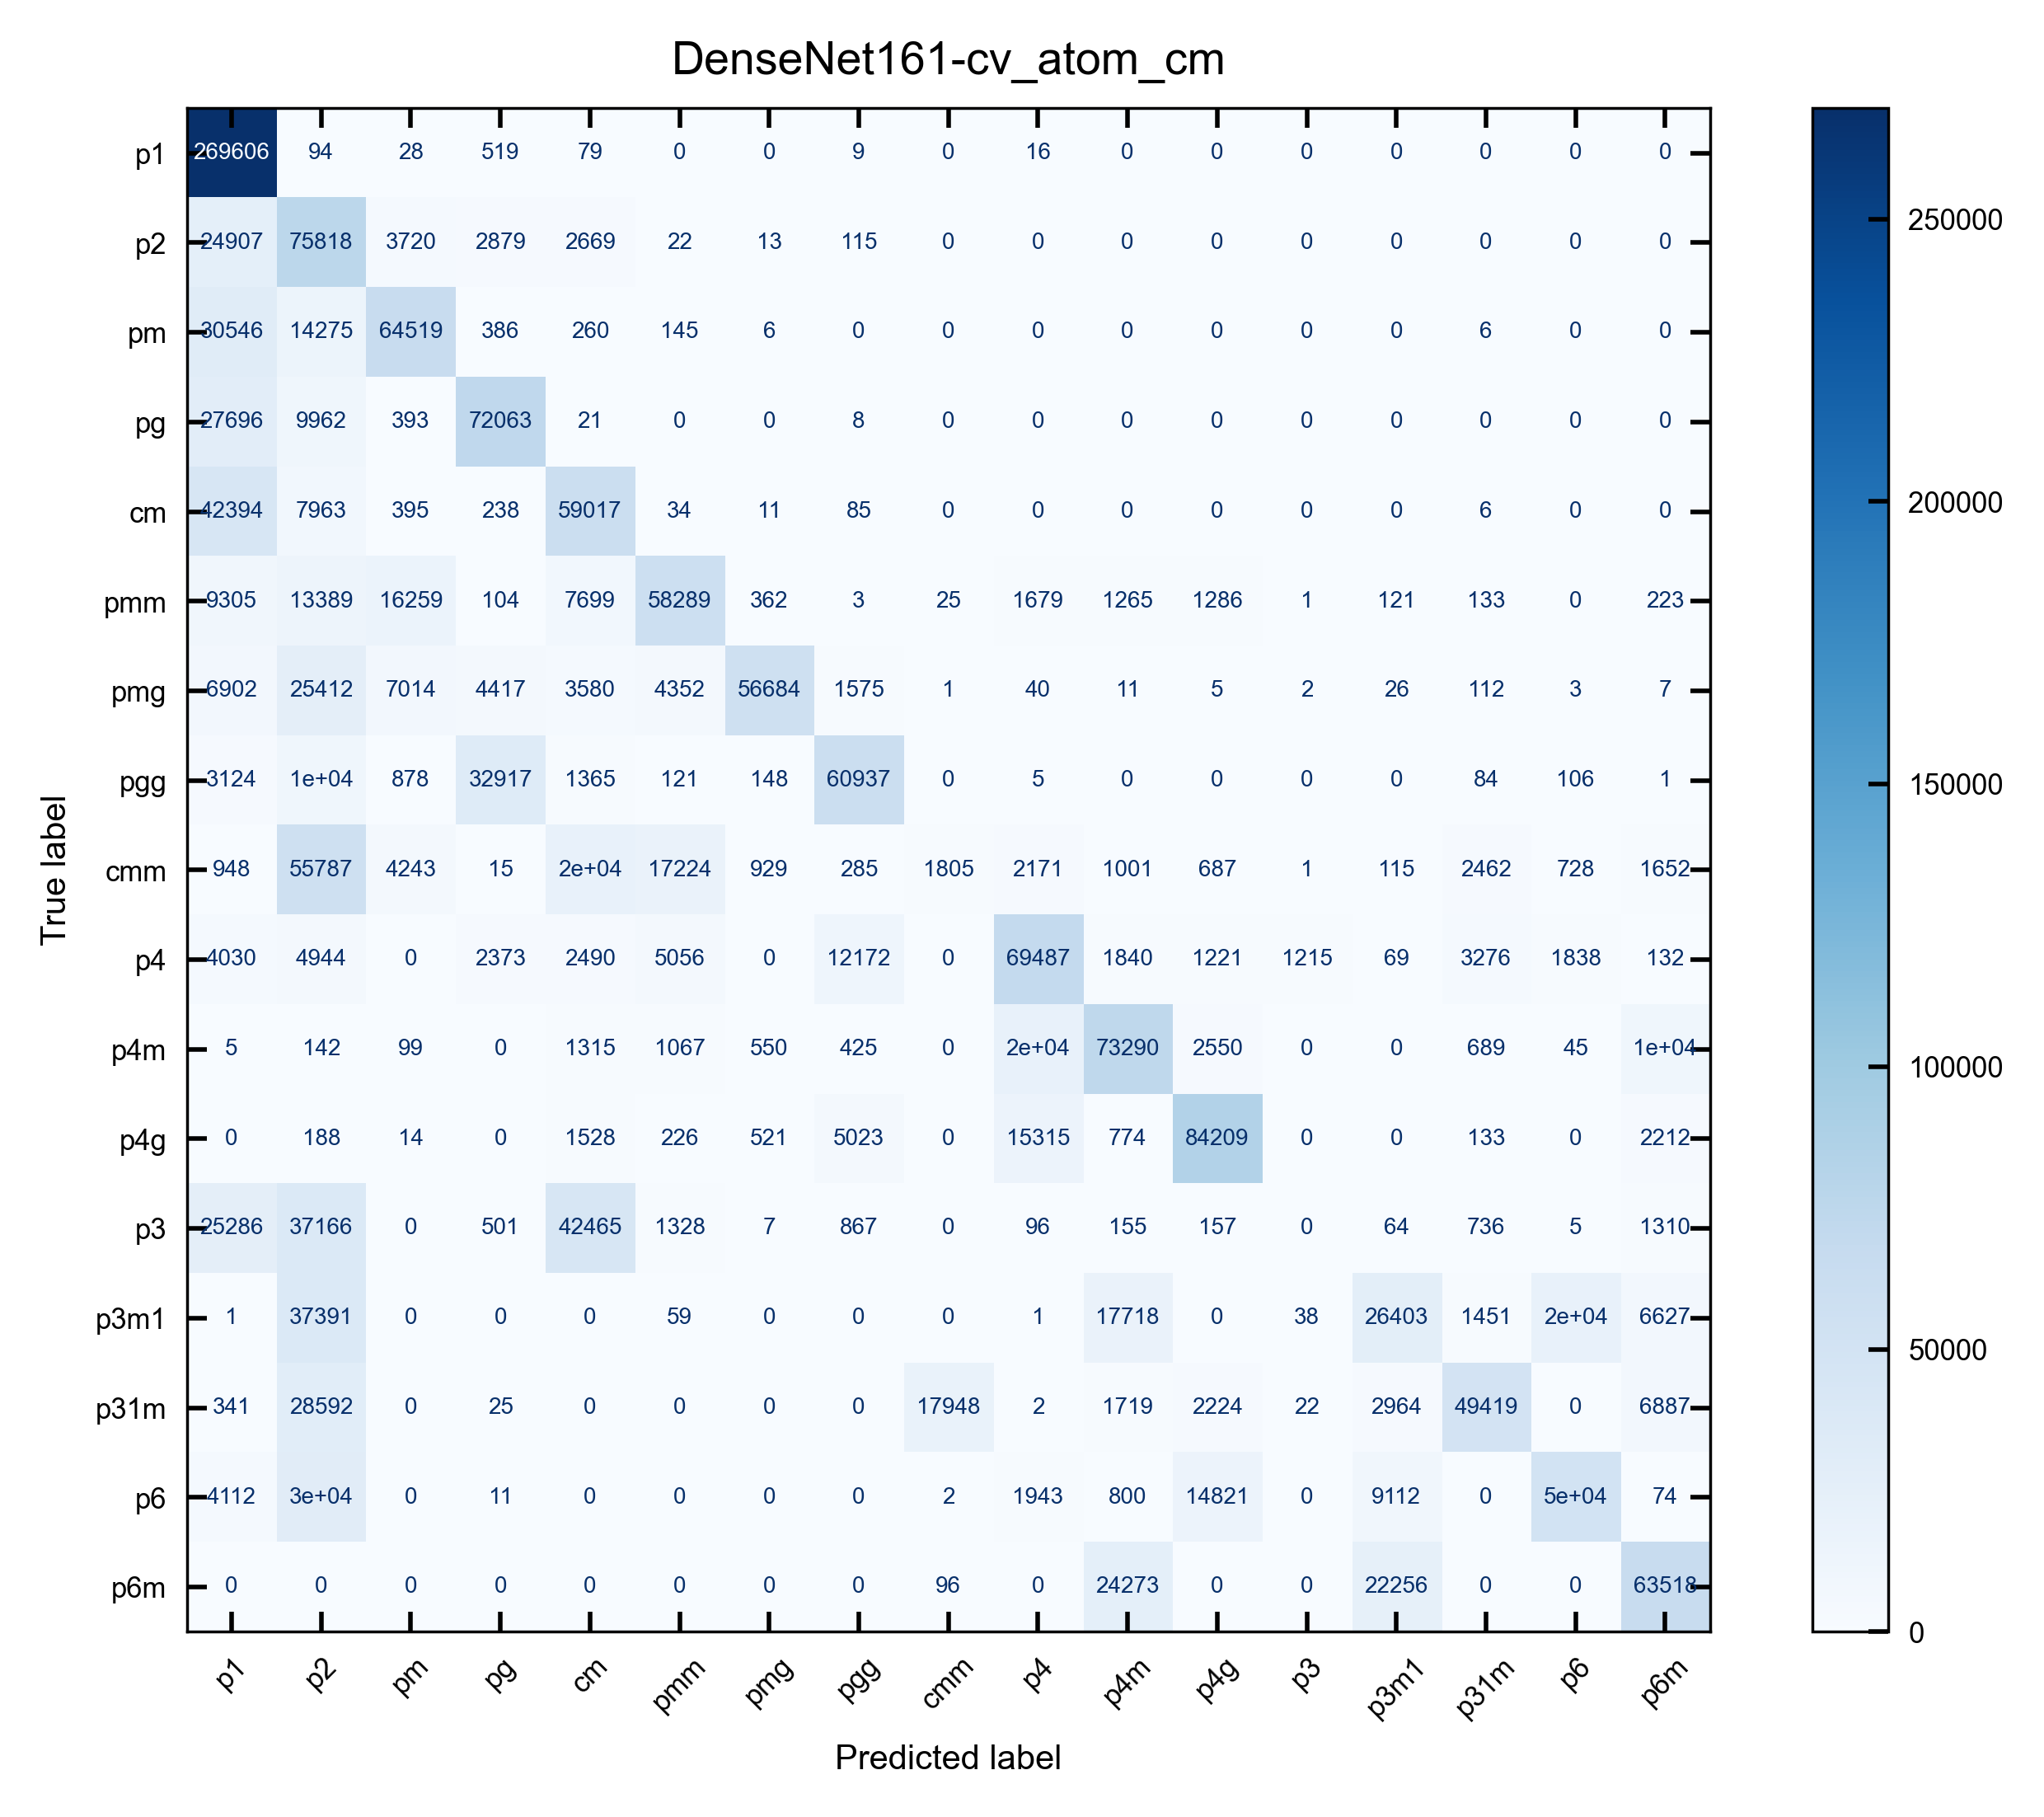

printing set for seaborn


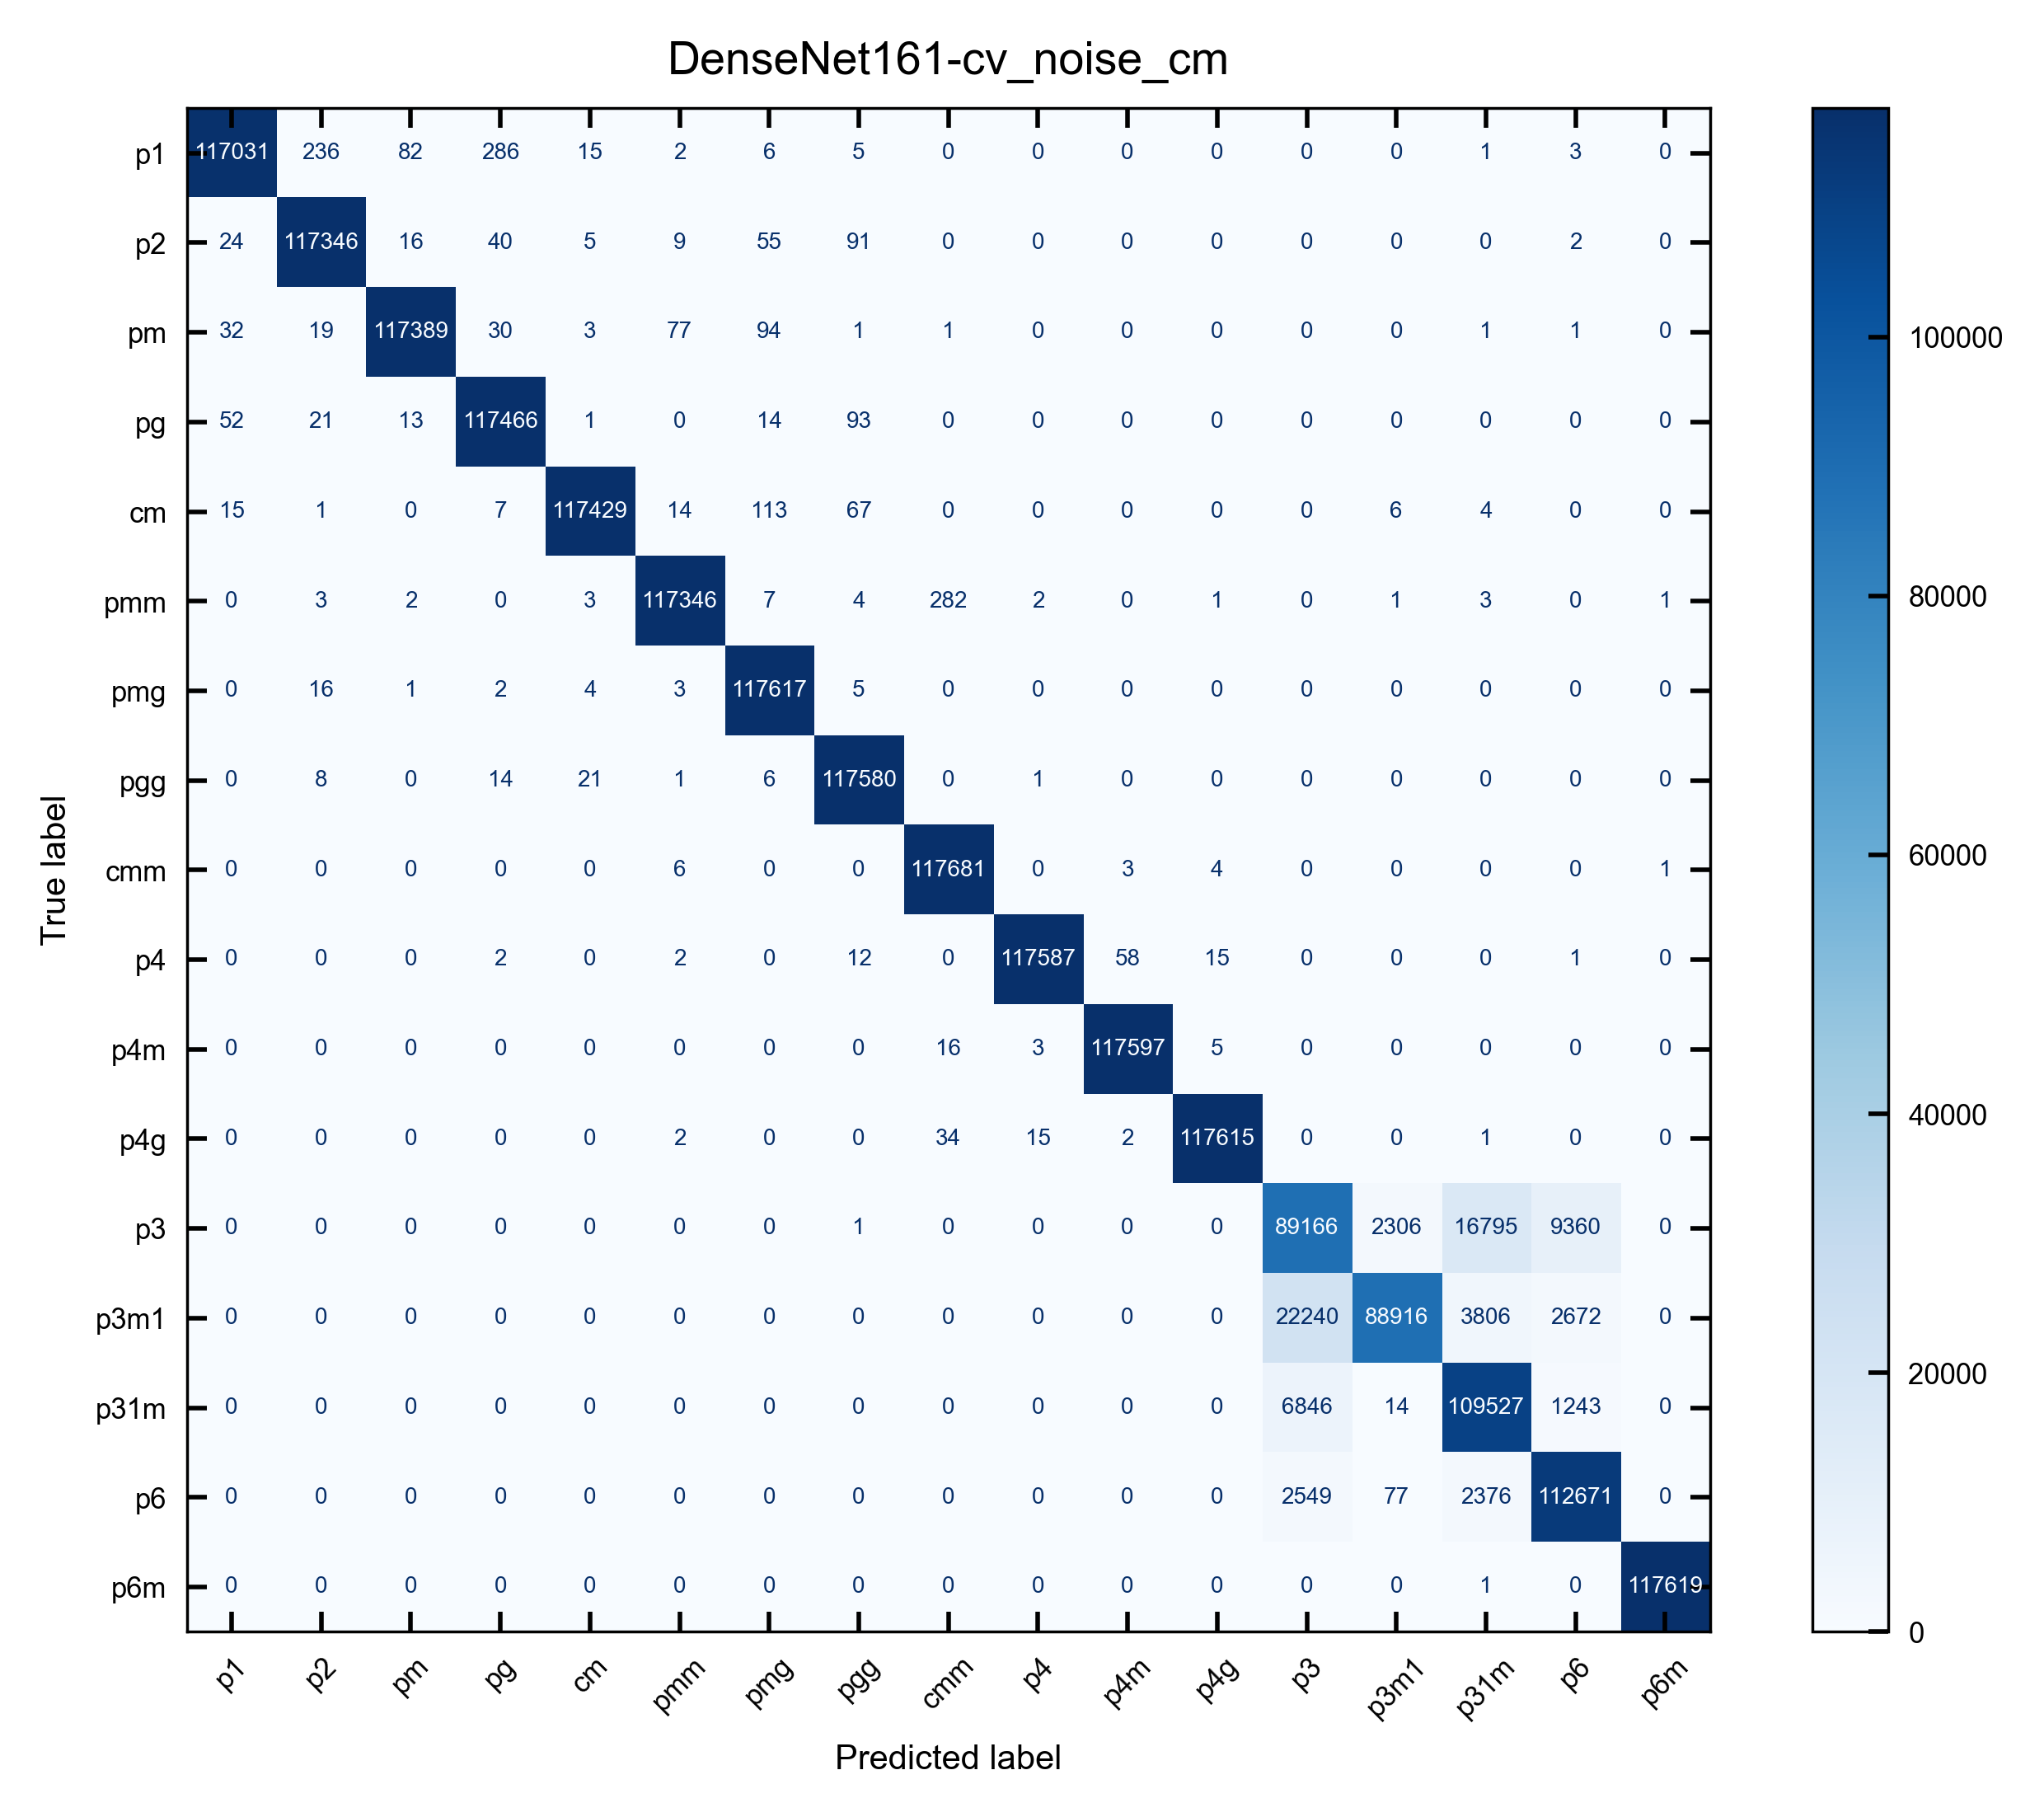

In [7]:
files = glob.glob(f'../../../saved_results/Benchmark/DenseNet161/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']
show_cm(files, keywords, title_head='DenseNet161-', file_path=f'../../../figures/Benchmark/DenseNet161/', cm_style='simple', fig_style='printing', font_size=4)

### visualize confusions in compact layout

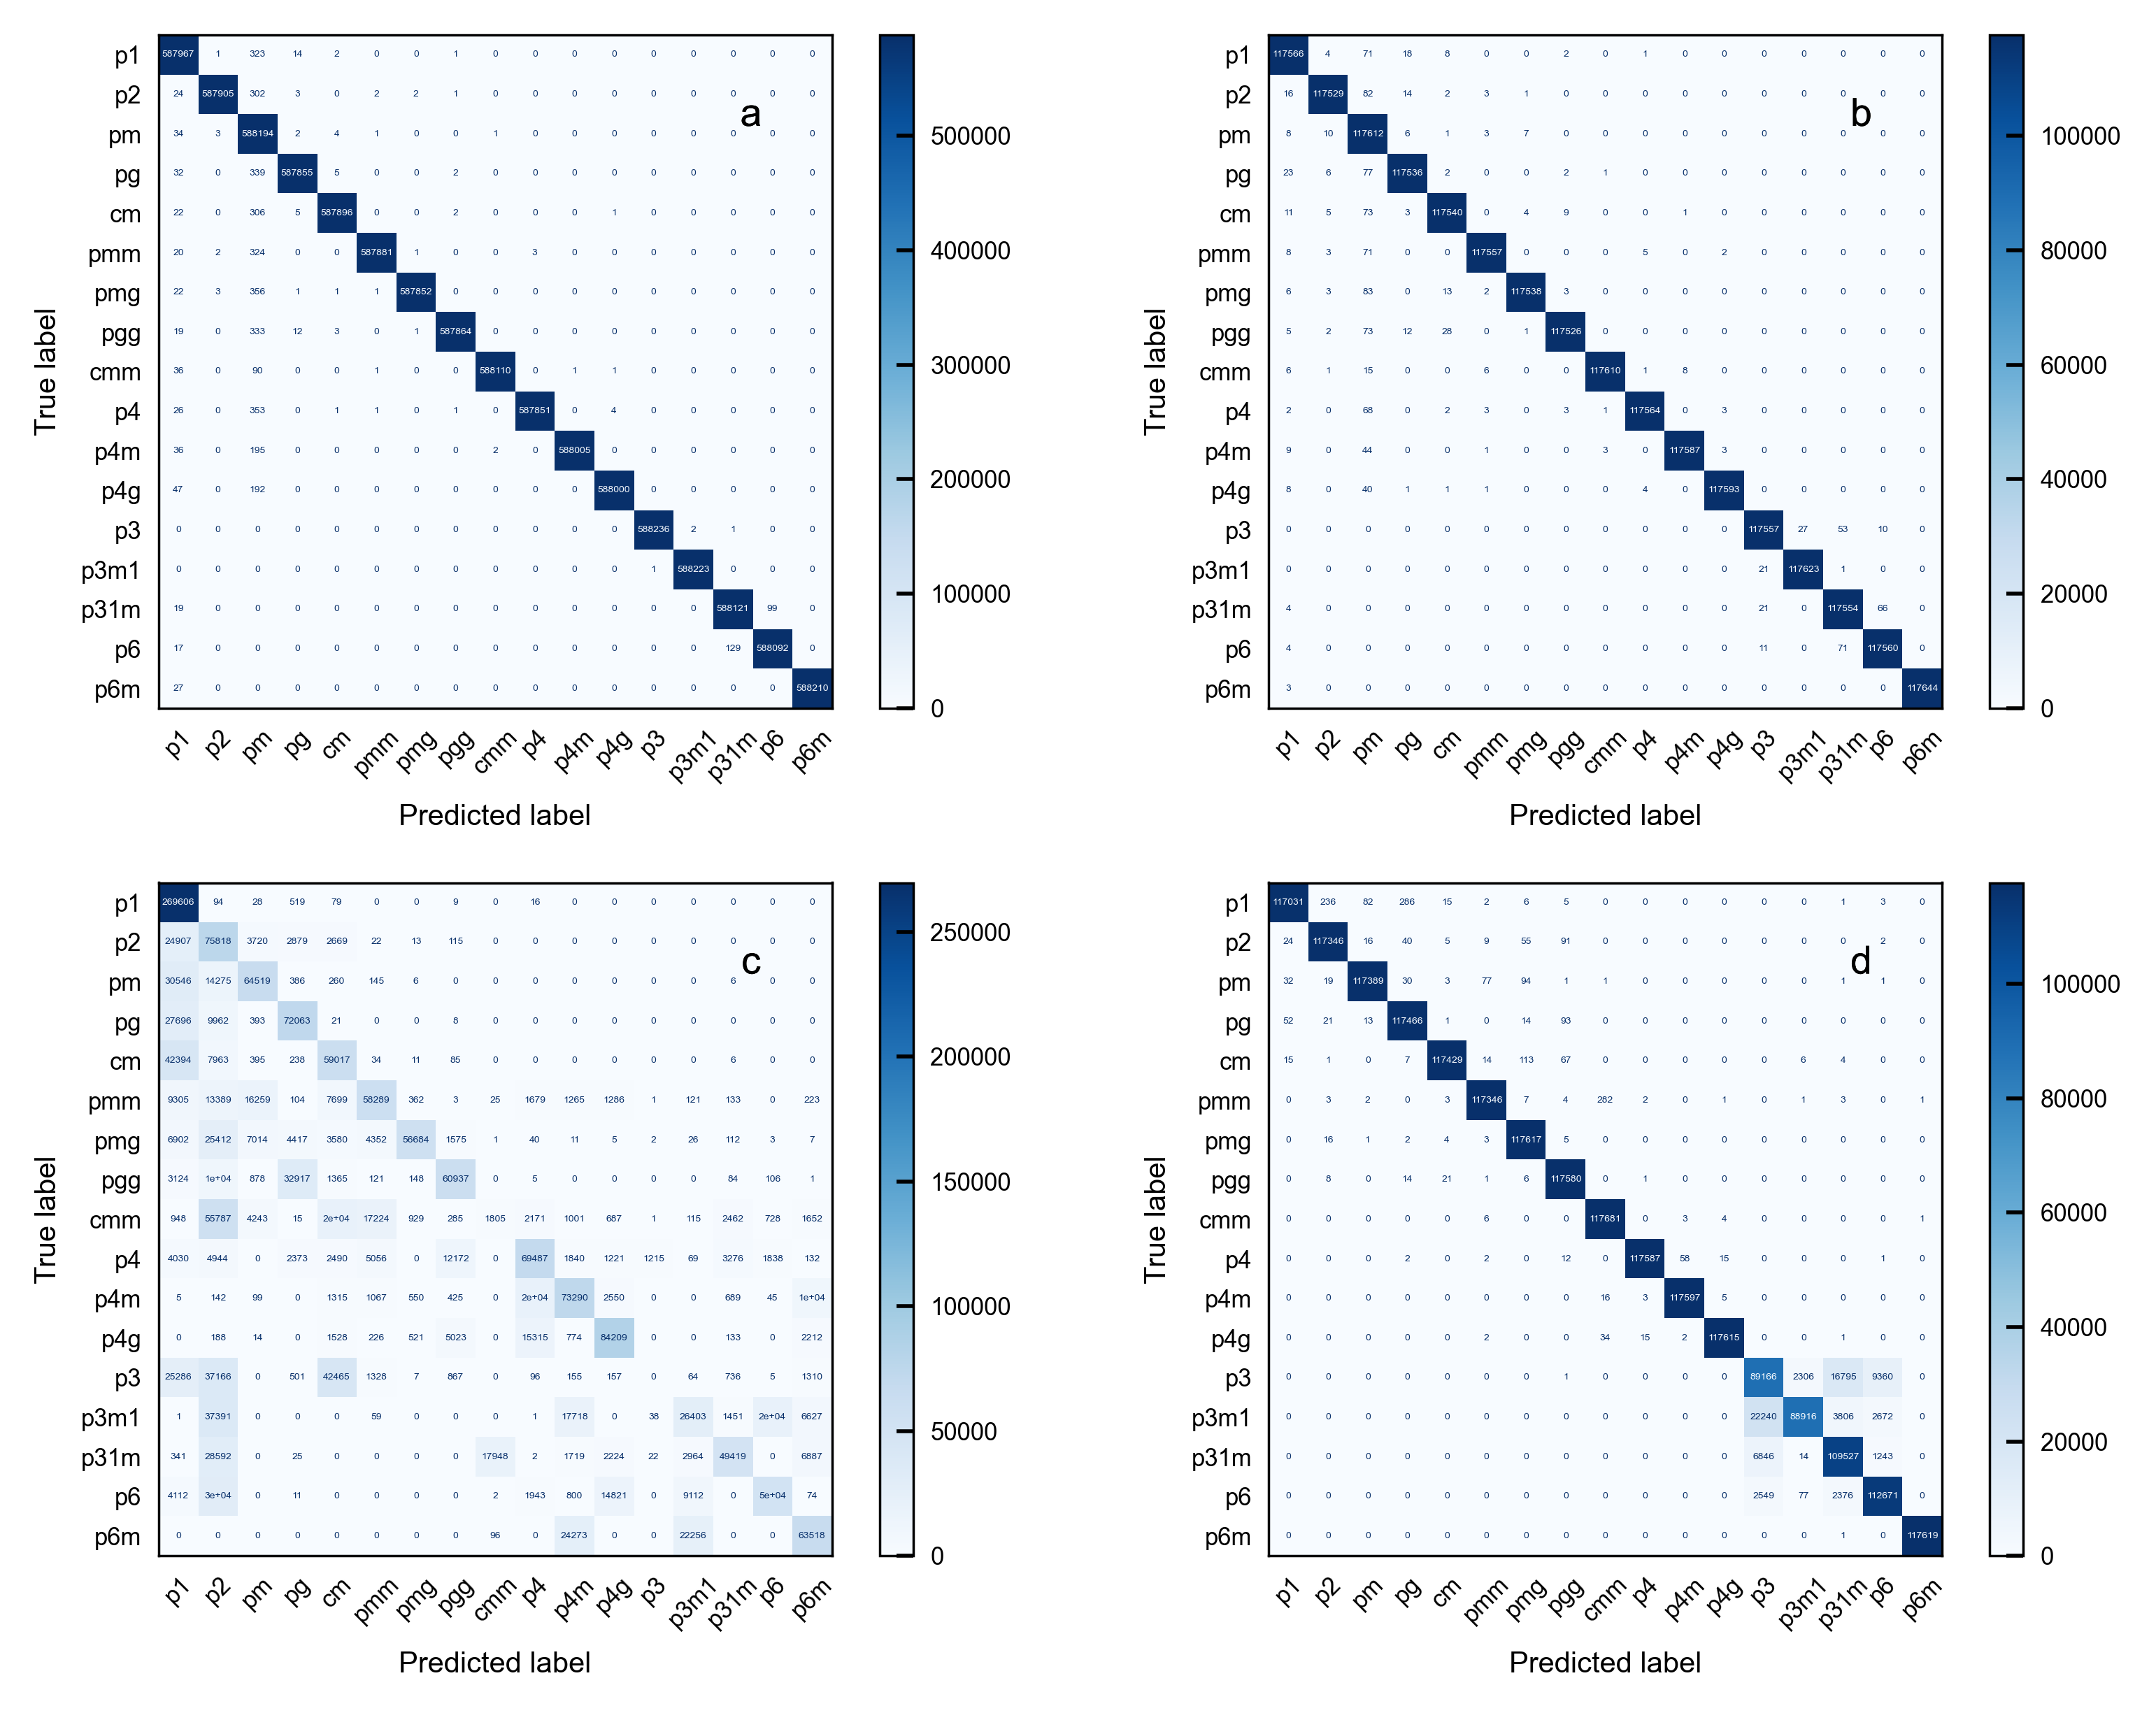

In [6]:
files = glob.glob(f'../../../saved_results/Benchmark/DenseNet161/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']

show_cm(files, keywords, summary=True, title_head=None, cm_style='simple', fig_style='printing', font_size=2,
        file_path='../../../figures/Benchmark/DenseNet161/Summary_cm-DenseNet161')

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font '] = 'Helvetica Medium Condensed'  # or any other available sans-serif font

In [1]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']

order = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']
def sort_key(file_path):
    for index, key in enumerate(order):
        if key in file_path:
            return index
    return len(order)

files = glob.glob(f'../../../saved_results/Benchmark/DenseNet161/*')
sorted_files = sorted(files, key=sort_key)
for file, group in zip(sorted_files, order):
    cm = np.load(file)
    plot_cm(cm, symmetry_classes, title='DenseNet161 - '+group, cm_style='simple', fig_style='printing', font_size=4)

NameError: name 'glob' is not defined

### visualize confusions in compact layout

In [9]:
from matplotlib.font_manager import findSystemFonts
findSystemFonts()

['/usr/share/fonts/truetype/lato/Lato-BlackItalic.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Light.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Italic.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Semibold.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Medium.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Thin.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Hairline.ttf',
 '/usr/share/fonts/truetype/lato/Lato-LightItalic.ttf',
 '/usr/share/fonts/truetype/lato/Lato-MediumItalic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf',
 '/usr/share/fonts/true

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

Summary_cm-01122024-benchmark


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

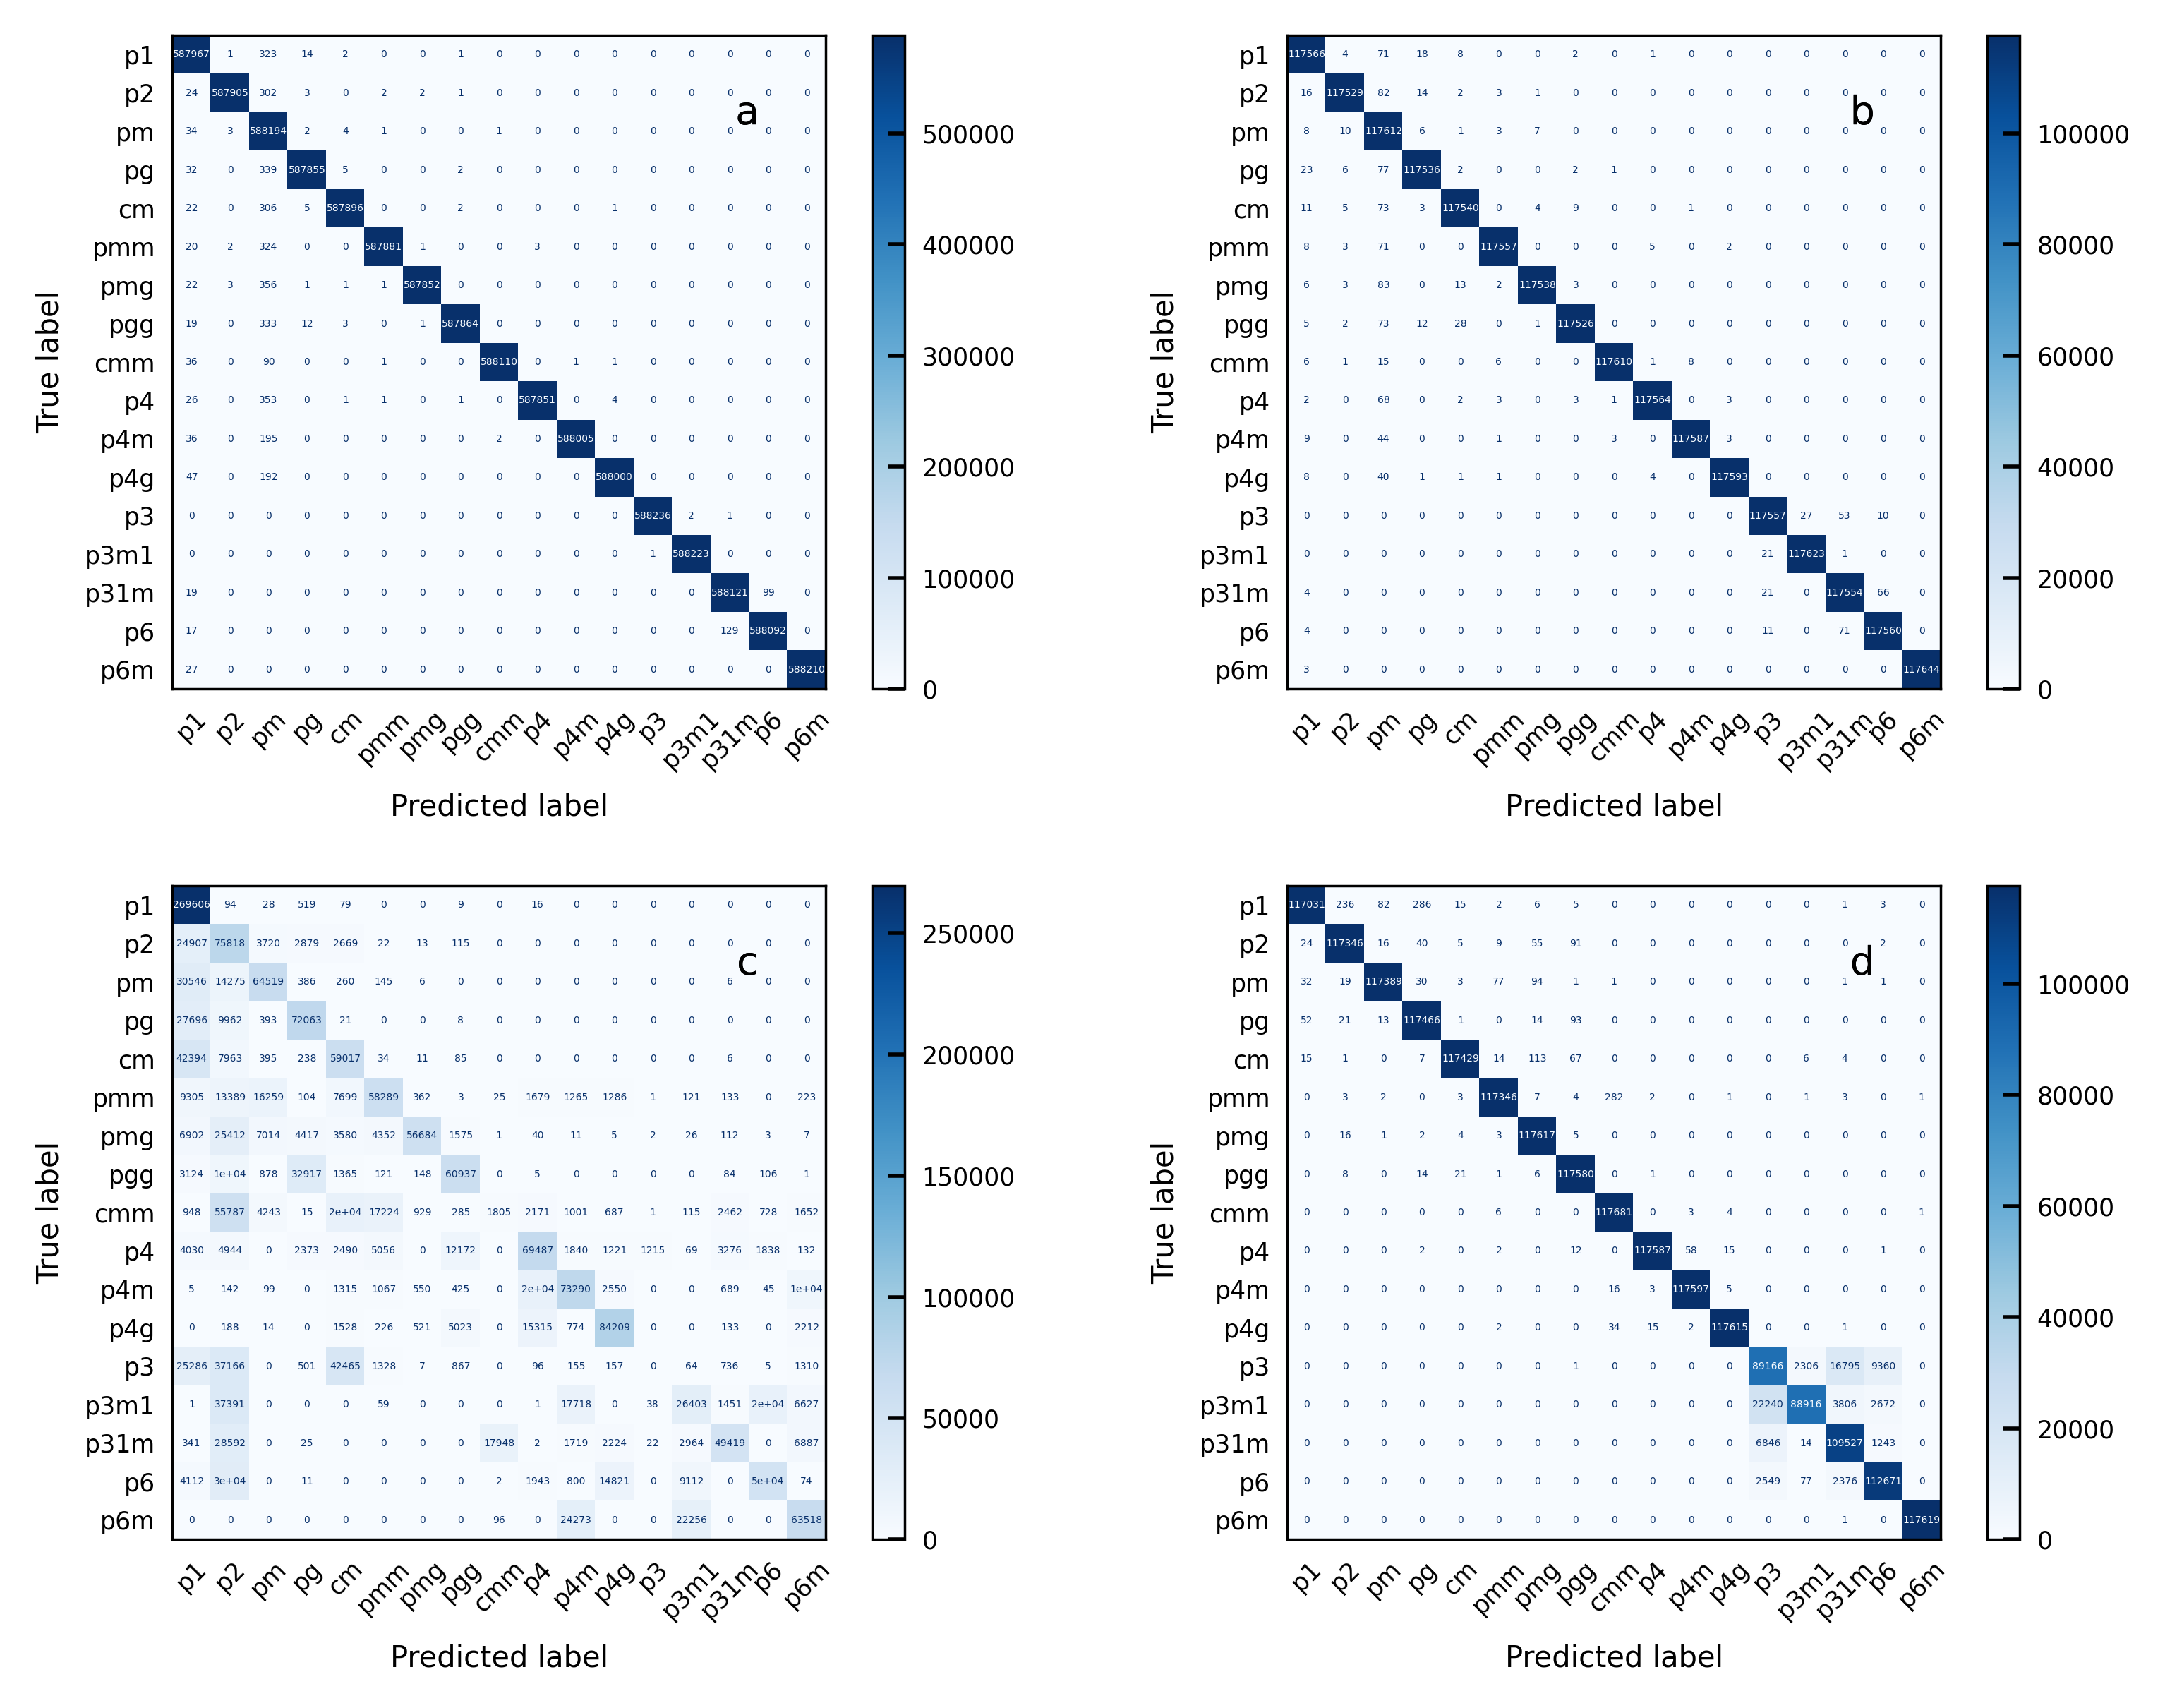

In [11]:
# print(sorted_files)
NAME = 'Summary_cm-' + '-'.join(os.path.basename(sorted_files[0]).split('-')[:2])
print(NAME)

fig, axes = plt.subplots(2, 2, figsize=(6.5, 5))
for i, (ax, file) in enumerate(zip(axes.flatten(), sorted_files)):
    cm = np.load(file)
    plot_cm(cm, symmetry_classes, title=None, ax=ax, cm_style='simple', fig_style='printing', fig_index=i, font_size=2)
plt.tight_layout()
plt.savefig(f'../../../figures/Benchmark/DenseNet161/{NAME}.png')
plt.savefig(f'../../../figures/Benchmark/DenseNet161/{NAME}.svg')
plt.show()